In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import tifffile as tiff
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from copy import deepcopy
import random

In [2]:
# Set seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed
set_seed(42)

In [3]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Custom Dataset class
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.tiff')]
        #we don't need to resize into 96*96 because we are doing that in below contrastive transform (self.resize_transform = transforms.resize((96,96)))
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")
        
        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0
        
        # Convert to a torch tensor
        image = torch.tensor(image, dtype=torch.float32)
        
        if self.transform:
            image1 = self.transform(image)
            image2 = self.transform(image)
        return image1, image2, image

# Data augmentation similar to the tutorial
contrast_transforms = transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(size=96),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)], p=0.8),
    #transforms.RandomGrayscale(p=0.2),
    #transforms.GaussianBlur(kernel_size=9),
])

# Create the dataset
image_dir = r"../../tiff_experiment_unsupervised_data/combined"

dataset = ImageDataset(image_dir=image_dir, transform=contrast_transforms)
batch_size = 16

# Function to split dataset with explicit percentage
def split_dataset(dataset, val_percentage):
    val_size = int(len(dataset) * val_percentage)
    train_size = len(dataset) - val_size
    return random_split(dataset, [train_size, val_size])

# Split the dataset with 20% for validation
val_percentage = 0.2
train_dataset, val_dataset = split_dataset(dataset, val_percentage)

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=0) #num_workers=os.cpu count() using cluster gpu
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=0)

def compute_mean_std(dataloader):
    mean = 0.
    std = 0.
    nb_samples = 0.
    for images, _ in dataloader:
        batch_samples = images.size(0)  # batch size (the last batch can have smaller size)
        images = images.view(batch_samples, images.size(1), -1)  # reshape to (N, C, H*W)
        mean += images.mean(2).mean(0)  # calculate mean per channel
        std += images.std(2).std(0)  # calculate std per channel
        nb_samples += batch_samples
    
    mean /= nb_samples
    std /= nb_samples
    return mean, std


In [5]:
for i, (image1, image2, image) in enumerate(train_loader):
    print(f"Batch {i}:")
    print(f"  Image1: {image1.shape}")
    print(f"  Image2: {image2.shape}")
    print(f"  image: {image.shape}")
    break

Batch 0:
  Image1: torch.Size([16, 3, 96, 96])
  Image2: torch.Size([16, 3, 96, 96])
  image: torch.Size([16, 3, 2054, 2456])


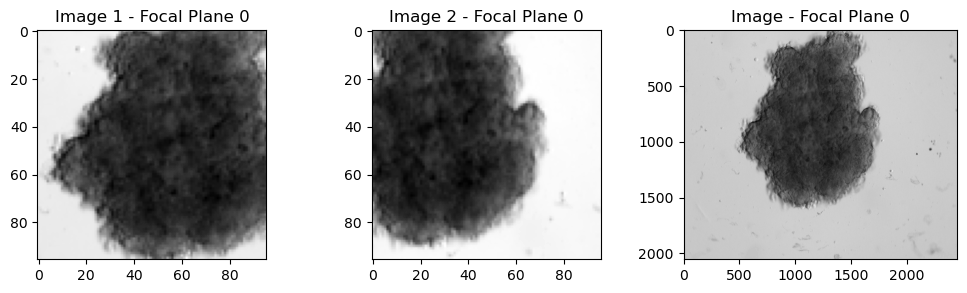

In [6]:
for i, (image1, image2, image) in enumerate(train_loader):
    # Select the first focal plane (layer) for visualization
    layer_to_visualize = 0  # Change this to 1 or 2 if you want other layers
    
    plt.figure(figsize=(10, 3))
    
    # Normalize the 16-bit image to range [0, 1] for visualization
    image1_normalized = image1[0, layer_to_visualize].float()
    image2_normalized = image2[0, layer_to_visualize].float()
    image_normalized = image[0, layer_to_visualize].float()
    
    # Plot Image1
    plt.subplot(1, 3, 1)
    plt.imshow(image1_normalized, cmap='gray')
    plt.title(f'Image 1 - Focal Plane {layer_to_visualize}')
    
    # Plot Image2
    plt.subplot(1, 3, 2)
    plt.imshow(image2_normalized, cmap='gray')
    plt.title(f'Image 2 - Focal Plane {layer_to_visualize}')
    
    # Plot Image
    plt.subplot(1, 3, 3)
    plt.imshow(image_normalized, cmap='gray')
    plt.title(f'Image - Focal Plane {layer_to_visualize}')
    
    plt.tight_layout()
    plt.show()
    break  # Exit after showing the first batch


In [7]:
class SimCLR(nn.Module):
    def __init__(self, hidden_dim, lr, temperature, weight_decay):
        super().__init__()
        self.temperature = temperature
        
        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
        
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, 20)  # Output layer with hidden_dim output
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)
        self.lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=50, eta_min=lr / 50)

    def forward(self, x):
        return self.convnet(x)

    def info_nce_loss(self, imgs1, imgs2, device):

        imgs = torch.cat((imgs1, imgs2), dim=0)  # Concatenate along the batch dimension
        imgs = imgs.to(device)  # Move images to the device

        # Encode all images
        feats = self.forward(imgs)
    
        # Calculate cosine similarity
        cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
    
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
    
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
    
        # Normalize similarity scores by temperature
        cos_sim = cos_sim / self.temperature

        # InfoNCE loss
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Accuracy calculations
        # Create a combination of positive and negative similarities for ranking
        comb_sim = torch.cat([cos_sim[pos_mask][:, None],  # Positive example in first position
                          cos_sim.masked_fill(pos_mask, -9e15)], dim=-1)
    
        # Sort and get the ranking position of the positive example
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
    
        # Compute accuracy metrics
        top1_acc = (sim_argsort == 0).float().mean()  # Top-1 accuracy
        top5_acc = (sim_argsort < 5).float().mean()   # Top-5 accuracy
        mean_pos = 1 + sim_argsort.float().mean()     # Mean position of the positive example

        return nll, top1_acc, top5_acc, mean_pos

    def train_epoch(self, train_loader, device):
        self.train()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        for batch in tqdm(train_loader, desc="Training", leave=False):
            imgs1, imgs2, _ = batch
            imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device
        
            self.optimizer.zero_grad()

            # Calculate loss and accuracy metrics
            loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

            loss.backward()
            self.optimizer.step()
            self.lr_scheduler.step()

            # Accumulate metrics
            total_loss += loss.item()
            total_top1_acc += top1_acc.item()
            total_top5_acc += top5_acc.item()
            total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(train_loader)
        avg_top1_acc = total_top1_acc / len(train_loader)
        avg_top5_acc = total_top5_acc / len(train_loader)
        avg_mean_pos = total_mean_pos / len(train_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

    def validate_epoch(self, val_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(val_loader)
        avg_top1_acc = total_top1_acc / len(val_loader)
        avg_top5_acc = total_top5_acc / len(val_loader)
        avg_mean_pos = total_mean_pos / len(val_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

In [8]:
def plot_curves(train_losses, val_losses, train_top1_accs, val_top1_accs, train_top5_accs, val_top5_accs, train_mean_pos, val_mean_pos):
    epochs = range(1, len(train_losses) + 1)
    
    # Plot loss
    plt.figure(figsize=(16, 10))
    
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Top-1 accuracy
    plt.subplot(2, 2, 2)
    plt.plot(epochs, train_top1_accs, 'bo-', label='Training Top-1 Accuracy')
    plt.plot(epochs, val_top1_accs, 'ro-', label='Validation Top-1 Accuracy')
    plt.title('Training and Validation Top-1 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Top-1 Accuracy (%)')
    plt.legend()

    # Plot Top-5 accuracy
    plt.subplot(2, 2, 3)
    plt.plot(epochs, train_top5_accs, 'bo-', label='Training Top-5 Accuracy')
    plt.plot(epochs, val_top5_accs, 'ro-', label='Validation Top-5 Accuracy')
    plt.title('Training and Validation Top-5 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Top-5 Accuracy (%)')
    plt.legend()

    # Plot Mean Positive Position
    plt.subplot(2, 2, 4)
    plt.plot(epochs, train_mean_pos, 'bo-', label='Training Mean Positive Position')
    plt.plot(epochs, val_mean_pos, 'ro-', label='Validation Mean Positive Position')
    plt.title('Training and Validation Mean Positive Position')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Position')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [9]:
def train_simclr(batch_size, max_epochs=50, hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model = SimCLR(hidden_dim=hidden_dim, lr=lr, temperature=temperature, weight_decay=weight_decay).to(device)
    
    # Lists to store the metrics
    train_losses, val_losses = [], []
    train_top1_accs, val_top1_accs = [], []
    train_top5_accs, val_top5_accs = [], []
    train_mean_pos, val_mean_pos = [], []

    start_time = time.time()

    for epoch in range(max_epochs):
        epoch_start_time = time.time()

        # Train and validate the model
        train_loss, train_top1_acc, train_top5_acc, train_mean_pos_val = model.train_epoch(train_loader, device)
        val_loss, val_top1_acc, val_top5_acc, val_mean_pos_val = model.validate_epoch(val_loader, device)
        
        # Store the metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_top1_accs.append(train_top1_acc)
        val_top1_accs.append(val_top1_acc)
        train_top5_accs.append(train_top5_acc)
        val_top5_accs.append(val_top5_acc)
        train_mean_pos.append(train_mean_pos_val)
        val_mean_pos.append(val_mean_pos_val)
        
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time

        # Print metrics for the current epoch
        print(f"Epoch {epoch+1}/{max_epochs} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Top-1 Acc: {train_top1_acc:.2f}% | Top-5 Acc: {train_top5_acc:.2f}% | "
              f"Mean Pos: {train_mean_pos_val:.2f} | "
              f"Val Loss: {val_loss:.4f} | Top-1 Acc: {val_top1_acc:.2f}% | "
              f"Top-5 Acc: {val_top5_acc:.2f}% | Mean Pos: {val_mean_pos_val:.2f} | "
              f"Time Taken: {epoch_duration:.2f} seconds")

    end_time = time.time()
    total_duration = end_time - start_time
    print(f"Total Training Time: {total_duration:.2f} seconds")

    # Plot results
    plot_curves(train_losses, val_losses, train_top1_accs, val_top1_accs, train_top5_accs, val_top5_accs, train_mean_pos, val_mean_pos)

    return model

Using device: cuda


Epoch 1/50 | Train Loss: 3.0655 | Top-1 Acc: 0.10% | Top-5 Acc: 0.42% | Mean Pos: 9.13 | Val Loss: 2.6904 | Top-1 Acc: 0.17% | Top-5 Acc: 0.52% | Mean Pos: 6.27 | Time Taken: 28.10 seconds


Epoch 2/50 | Train Loss: 2.7111 | Top-1 Acc: 0.19% | Top-5 Acc: 0.51% | Mean Pos: 6.65 | Val Loss: 2.7751 | Top-1 Acc: 0.18% | Top-5 Acc: 0.51% | Mean Pos: 7.20 | Time Taken: 27.61 seconds


Epoch 3/50 | Train Loss: 2.6139 | Top-1 Acc: 0.16% | Top-5 Acc: 0.54% | Mean Pos: 6.33 | Val Loss: 2.5690 | Top-1 Acc: 0.18% | Top-5 Acc: 0.59% | Mean Pos: 5.81 | Time Taken: 28.96 seconds


Epoch 4/50 | Train Loss: 2.4980 | Top-1 Acc: 0.26% | Top-5 Acc: 0.62% | Mean Pos: 5.53 | Val Loss: 2.5821 | Top-1 Acc: 0.20% | Top-5 Acc: 0.59% | Mean Pos: 5.80 | Time Taken: 26.78 seconds


Epoch 5/50 | Train Loss: 2.3761 | Top-1 Acc: 0.25% | Top-5 Acc: 0.67% | Mean Pos: 4.98 | Val Loss: 2.6743 | Top-1 Acc: 0.20% | Top-5 Acc: 0.60% | Mean Pos: 5.88 | Time Taken: 26.15 seconds


Epoch 6/50 | Train Loss: 2.5745 | Top-1 Acc: 0.20% | Top-5 Acc: 0.61% | Mean Pos: 5.84 | Val Loss: 2.8796 | Top-1 Acc: 0.18% | Top-5 Acc: 0.53% | Mean Pos: 7.13 | Time Taken: 27.03 seconds


Epoch 7/50 | Train Loss: 2.3033 | Top-1 Acc: 0.27% | Top-5 Acc: 0.71% | Mean Pos: 4.69 | Val Loss: 2.3455 | Top-1 Acc: 0.25% | Top-5 Acc: 0.73% | Mean Pos: 4.53 | Time Taken: 27.11 seconds


Epoch 8/50 | Train Loss: 2.0415 | Top-1 Acc: 0.34% | Top-5 Acc: 0.78% | Mean Pos: 3.83 | Val Loss: 2.0696 | Top-1 Acc: 0.35% | Top-5 Acc: 0.82% | Mean Pos: 3.58 | Time Taken: 26.99 seconds


Epoch 9/50 | Train Loss: 2.0380 | Top-1 Acc: 0.35% | Top-5 Acc: 0.79% | Mean Pos: 3.78 | Val Loss: 2.0793 | Top-1 Acc: 0.34% | Top-5 Acc: 0.78% | Mean Pos: 3.80 | Time Taken: 27.82 seconds


Epoch 10/50 | Train Loss: 2.0079 | Top-1 Acc: 0.40% | Top-5 Acc: 0.82% | Mean Pos: 3.57 | Val Loss: 2.1047 | Top-1 Acc: 0.38% | Top-5 Acc: 0.81% | Mean Pos: 3.94 | Time Taken: 27.06 seconds


Epoch 11/50 | Train Loss: 2.2103 | Top-1 Acc: 0.30% | Top-5 Acc: 0.75% | Mean Pos: 4.27 | Val Loss: 2.3835 | Top-1 Acc: 0.29% | Top-5 Acc: 0.67% | Mean Pos: 4.96 | Time Taken: 26.49 seconds


Epoch 12/50 | Train Loss: 2.1513 | Top-1 Acc: 0.35% | Top-5 Acc: 0.75% | Mean Pos: 4.13 | Val Loss: 2.0299 | Top-1 Acc: 0.33% | Top-5 Acc: 0.82% | Mean Pos: 3.70 | Time Taken: 29.68 seconds


Epoch 13/50 | Train Loss: 1.8572 | Top-1 Acc: 0.38% | Top-5 Acc: 0.83% | Mean Pos: 3.30 | Val Loss: 1.8352 | Top-1 Acc: 0.40% | Top-5 Acc: 0.87% | Mean Pos: 3.02 | Time Taken: 26.96 seconds


Epoch 14/50 | Train Loss: 1.7641 | Top-1 Acc: 0.43% | Top-5 Acc: 0.83% | Mean Pos: 3.16 | Val Loss: 1.5281 | Top-1 Acc: 0.57% | Top-5 Acc: 0.91% | Mean Pos: 2.26 | Time Taken: 26.42 seconds


Epoch 15/50 | Train Loss: 1.7965 | Top-1 Acc: 0.48% | Top-5 Acc: 0.84% | Mean Pos: 3.20 | Val Loss: 2.0788 | Top-1 Acc: 0.32% | Top-5 Acc: 0.75% | Mean Pos: 4.11 | Time Taken: 25.66 seconds


Epoch 16/50 | Train Loss: 1.9817 | Top-1 Acc: 0.38% | Top-5 Acc: 0.78% | Mean Pos: 3.79 | Val Loss: 2.1384 | Top-1 Acc: 0.34% | Top-5 Acc: 0.84% | Mean Pos: 3.66 | Time Taken: 25.52 seconds


Epoch 17/50 | Train Loss: 2.1211 | Top-1 Acc: 0.33% | Top-5 Acc: 0.77% | Mean Pos: 4.11 | Val Loss: 2.1991 | Top-1 Acc: 0.38% | Top-5 Acc: 0.76% | Mean Pos: 4.25 | Time Taken: 25.93 seconds


Epoch 18/50 | Train Loss: 1.9282 | Top-1 Acc: 0.38% | Top-5 Acc: 0.80% | Mean Pos: 3.55 | Val Loss: 1.7261 | Top-1 Acc: 0.40% | Top-5 Acc: 0.88% | Mean Pos: 2.96 | Time Taken: 25.86 seconds


Epoch 19/50 | Train Loss: 1.7911 | Top-1 Acc: 0.45% | Top-5 Acc: 0.83% | Mean Pos: 3.22 | Val Loss: 1.7188 | Top-1 Acc: 0.45% | Top-5 Acc: 0.85% | Mean Pos: 2.92 | Time Taken: 25.83 seconds


Epoch 20/50 | Train Loss: 1.6297 | Top-1 Acc: 0.44% | Top-5 Acc: 0.88% | Mean Pos: 2.77 | Val Loss: 2.3245 | Top-1 Acc: 0.43% | Top-5 Acc: 0.73% | Mean Pos: 4.36 | Time Taken: 31.40 seconds


Epoch 21/50 | Train Loss: 2.1034 | Top-1 Acc: 0.32% | Top-5 Acc: 0.77% | Mean Pos: 3.77 | Val Loss: 2.3571 | Top-1 Acc: 0.31% | Top-5 Acc: 0.76% | Mean Pos: 4.34 | Time Taken: 39.79 seconds


Epoch 22/50 | Train Loss: 2.1736 | Top-1 Acc: 0.32% | Top-5 Acc: 0.73% | Mean Pos: 4.31 | Val Loss: 2.1732 | Top-1 Acc: 0.29% | Top-5 Acc: 0.77% | Mean Pos: 3.70 | Time Taken: 33.10 seconds


Epoch 23/50 | Train Loss: 2.1125 | Top-1 Acc: 0.34% | Top-5 Acc: 0.77% | Mean Pos: 3.89 | Val Loss: 1.8943 | Top-1 Acc: 0.36% | Top-5 Acc: 0.85% | Mean Pos: 3.17 | Time Taken: 26.29 seconds


Epoch 24/50 | Train Loss: 1.8171 | Top-1 Acc: 0.46% | Top-5 Acc: 0.84% | Mean Pos: 3.15 | Val Loss: 1.7861 | Top-1 Acc: 0.47% | Top-5 Acc: 0.86% | Mean Pos: 2.93 | Time Taken: 31.10 seconds


Epoch 25/50 | Train Loss: 1.7900 | Top-1 Acc: 0.43% | Top-5 Acc: 0.81% | Mean Pos: 3.27 | Val Loss: 1.6414 | Top-1 Acc: 0.52% | Top-5 Acc: 0.85% | Mean Pos: 2.75 | Time Taken: 37.58 seconds


Epoch 26/50 | Train Loss: 1.7818 | Top-1 Acc: 0.45% | Top-5 Acc: 0.82% | Mean Pos: 3.20 | Val Loss: 2.1291 | Top-1 Acc: 0.40% | Top-5 Acc: 0.75% | Mean Pos: 3.88 | Time Taken: 31.87 seconds


Epoch 27/50 | Train Loss: 1.9483 | Top-1 Acc: 0.44% | Top-5 Acc: 0.80% | Mean Pos: 3.63 | Val Loss: 2.2203 | Top-1 Acc: 0.32% | Top-5 Acc: 0.72% | Mean Pos: 4.57 | Time Taken: 40.64 seconds


Epoch 28/50 | Train Loss: 2.0038 | Top-1 Acc: 0.42% | Top-5 Acc: 0.79% | Mean Pos: 3.75 | Val Loss: 1.8913 | Top-1 Acc: 0.45% | Top-5 Acc: 0.83% | Mean Pos: 3.21 | Time Taken: 39.82 seconds


Epoch 29/50 | Train Loss: 1.7713 | Top-1 Acc: 0.44% | Top-5 Acc: 0.84% | Mean Pos: 3.18 | Val Loss: 1.7703 | Top-1 Acc: 0.43% | Top-5 Acc: 0.90% | Mean Pos: 3.05 | Time Taken: 39.64 seconds


Epoch 30/50 | Train Loss: 1.6625 | Top-1 Acc: 0.48% | Top-5 Acc: 0.87% | Mean Pos: 2.85 | Val Loss: 1.5718 | Top-1 Acc: 0.52% | Top-5 Acc: 0.92% | Mean Pos: 2.54 | Time Taken: 39.48 seconds


Epoch 31/50 | Train Loss: 1.6063 | Top-1 Acc: 0.50% | Top-5 Acc: 0.87% | Mean Pos: 2.81 | Val Loss: 1.7331 | Top-1 Acc: 0.49% | Top-5 Acc: 0.88% | Mean Pos: 2.84 | Time Taken: 40.11 seconds


Epoch 32/50 | Train Loss: 1.7830 | Top-1 Acc: 0.48% | Top-5 Acc: 0.85% | Mean Pos: 3.21 | Val Loss: 1.9285 | Top-1 Acc: 0.39% | Top-5 Acc: 0.82% | Mean Pos: 3.35 | Time Taken: 38.73 seconds


Epoch 33/50 | Train Loss: 1.8414 | Top-1 Acc: 0.40% | Top-5 Acc: 0.82% | Mean Pos: 3.40 | Val Loss: 1.9665 | Top-1 Acc: 0.36% | Top-5 Acc: 0.81% | Mean Pos: 3.94 | Time Taken: 39.15 seconds


Epoch 34/50 | Train Loss: 1.7811 | Top-1 Acc: 0.44% | Top-5 Acc: 0.83% | Mean Pos: 3.18 | Val Loss: 1.6275 | Top-1 Acc: 0.49% | Top-5 Acc: 0.86% | Mean Pos: 2.64 | Time Taken: 32.47 seconds


Epoch 35/50 | Train Loss: 1.5327 | Top-1 Acc: 0.54% | Top-5 Acc: 0.89% | Mean Pos: 2.53 | Val Loss: 1.4280 | Top-1 Acc: 0.58% | Top-5 Acc: 0.91% | Mean Pos: 2.35 | Time Taken: 26.62 seconds


Epoch 36/50 | Train Loss: 1.5107 | Top-1 Acc: 0.55% | Top-5 Acc: 0.89% | Mean Pos: 2.55 | Val Loss: 1.7352 | Top-1 Acc: 0.47% | Top-5 Acc: 0.87% | Mean Pos: 3.01 | Time Taken: 27.24 seconds


Epoch 37/50 | Train Loss: 1.8939 | Top-1 Acc: 0.43% | Top-5 Acc: 0.82% | Mean Pos: 3.32 | Val Loss: 2.2968 | Top-1 Acc: 0.36% | Top-5 Acc: 0.71% | Mean Pos: 4.49 | Time Taken: 27.14 seconds


Epoch 38/50 | Train Loss: 2.0046 | Top-1 Acc: 0.41% | Top-5 Acc: 0.80% | Mean Pos: 3.64 | Val Loss: 1.9824 | Top-1 Acc: 0.40% | Top-5 Acc: 0.78% | Mean Pos: 3.78 | Time Taken: 27.19 seconds


Epoch 39/50 | Train Loss: 1.6557 | Top-1 Acc: 0.47% | Top-5 Acc: 0.86% | Mean Pos: 2.88 | Val Loss: 1.4036 | Top-1 Acc: 0.58% | Top-5 Acc: 0.93% | Mean Pos: 2.23 | Time Taken: 27.75 seconds


Epoch 40/50 | Train Loss: 1.6534 | Top-1 Acc: 0.45% | Top-5 Acc: 0.87% | Mean Pos: 2.79 | Val Loss: 1.4032 | Top-1 Acc: 0.51% | Top-5 Acc: 0.90% | Mean Pos: 2.41 | Time Taken: 36.95 seconds


Epoch 41/50 | Train Loss: 1.4139 | Top-1 Acc: 0.57% | Top-5 Acc: 0.91% | Mean Pos: 2.32 | Val Loss: 1.7036 | Top-1 Acc: 0.52% | Top-5 Acc: 0.88% | Mean Pos: 2.64 | Time Taken: 28.04 seconds


Epoch 42/50 | Train Loss: 1.5306 | Top-1 Acc: 0.51% | Top-5 Acc: 0.89% | Mean Pos: 2.65 | Val Loss: 1.5134 | Top-1 Acc: 0.59% | Top-5 Acc: 0.92% | Mean Pos: 2.43 | Time Taken: 26.54 seconds


Epoch 43/50 | Train Loss: 1.5678 | Top-1 Acc: 0.53% | Top-5 Acc: 0.87% | Mean Pos: 2.75 | Val Loss: 2.2843 | Top-1 Acc: 0.42% | Top-5 Acc: 0.76% | Mean Pos: 3.84 | Time Taken: 28.04 seconds


Epoch 44/50 | Train Loss: 1.5531 | Top-1 Acc: 0.57% | Top-5 Acc: 0.89% | Mean Pos: 2.77 | Val Loss: 1.7569 | Top-1 Acc: 0.38% | Top-5 Acc: 0.84% | Mean Pos: 2.93 | Time Taken: 39.41 seconds


Epoch 45/50 | Train Loss: 1.5746 | Top-1 Acc: 0.52% | Top-5 Acc: 0.90% | Mean Pos: 2.65 | Val Loss: 1.7194 | Top-1 Acc: 0.51% | Top-5 Acc: 0.87% | Mean Pos: 3.06 | Time Taken: 41.17 seconds


Epoch 46/50 | Train Loss: 1.5223 | Top-1 Acc: 0.52% | Top-5 Acc: 0.89% | Mean Pos: 2.59 | Val Loss: 1.4700 | Top-1 Acc: 0.55% | Top-5 Acc: 0.92% | Mean Pos: 2.36 | Time Taken: 41.23 seconds


Epoch 47/50 | Train Loss: 1.2471 | Top-1 Acc: 0.66% | Top-5 Acc: 0.93% | Mean Pos: 2.16 | Val Loss: 1.7913 | Top-1 Acc: 0.45% | Top-5 Acc: 0.87% | Mean Pos: 2.88 | Time Taken: 41.00 seconds


Epoch 48/50 | Train Loss: 1.6158 | Top-1 Acc: 0.55% | Top-5 Acc: 0.87% | Mean Pos: 2.72 | Val Loss: 1.7803 | Top-1 Acc: 0.49% | Top-5 Acc: 0.86% | Mean Pos: 3.05 | Time Taken: 35.56 seconds


Epoch 49/50 | Train Loss: 1.7632 | Top-1 Acc: 0.47% | Top-5 Acc: 0.83% | Mean Pos: 3.20 | Val Loss: 1.8875 | Top-1 Acc: 0.40% | Top-5 Acc: 0.80% | Mean Pos: 3.33 | Time Taken: 41.17 seconds


Epoch 50/50 | Train Loss: 1.5602 | Top-1 Acc: 0.52% | Top-5 Acc: 0.89% | Mean Pos: 2.76 | Val Loss: 1.5020 | Top-1 Acc: 0.48% | Top-5 Acc: 0.91% | Mean Pos: 2.57 | Time Taken: 41.25 seconds
Total Training Time: 1589.44 seconds


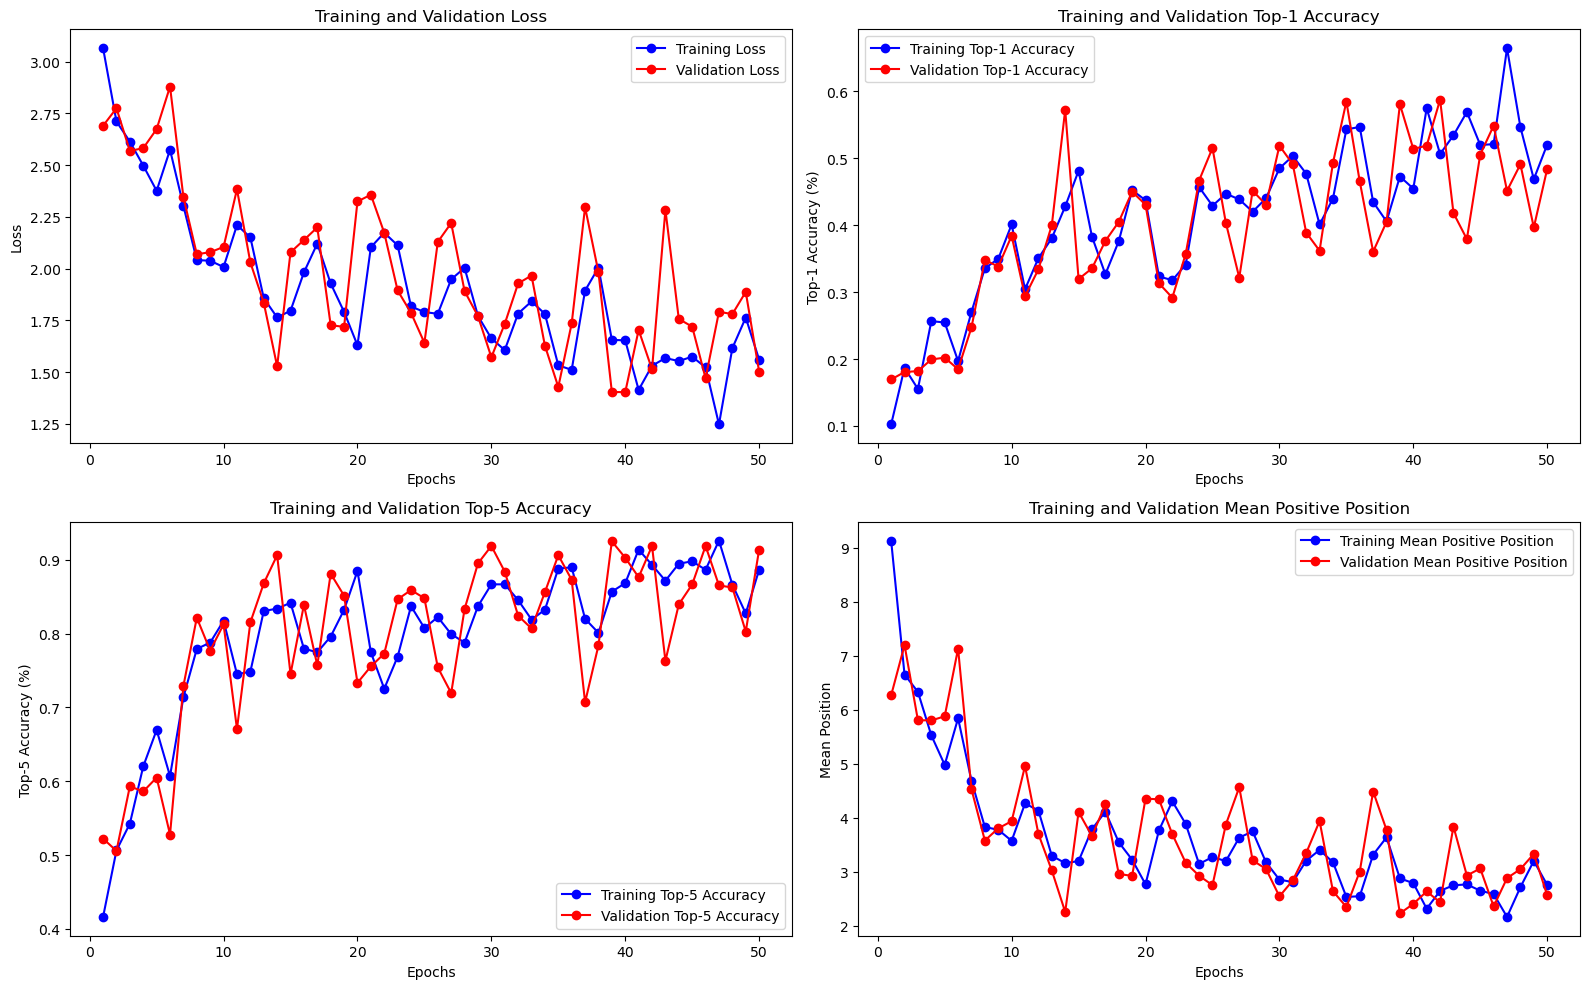

In [10]:
# Run the training script
simclr_model = train_simclr(batch_size=16, hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4, max_epochs=50)

# Clustering

In [11]:
class LabeledImageDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        #self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")

        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0

        # Convert to a torch tensor and add channel dimension
        image = torch.tensor(image, dtype=torch.float32)
        
        # Apply resize transform
        image = self.resize_transform(image)

        label = self.labels[idx]

        return image, label

def load_data(root_dir):
    classes = ['untreated', 'single_dose']   #classes = ['untreated', 'single_dose', 'drug_screened']
    image_files = []
    labels = []

    for idx, class_name in enumerate(classes):
        class_dir = os.path.join(root_dir, class_name)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir) if file.endswith('.tiff')]
        image_files.extend(files)
        labels.extend([idx] * len(files))
    
    # Check if the labels correctly reflect the classes
    print("Label distribution:", {classes[i]: labels.count(i) for i in range(len(classes))})

    return image_files, labels


# Directories for labeled data
image_dir = r"../../Data_supervised"

# Load data
image_files, labels = load_data(image_dir)

# Create the labeled datasets
labeled_dataset = LabeledImageDataset(image_files, labels)

# Define DataLoaders
batch_size = 16
loader_labeled = DataLoader(labeled_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=0)

Label distribution: {'untreated': 30, 'single_dose': 30}


In [12]:
for anchor,label in loader_labeled:
    print(anchor.shape, label.shape, anchor.dtype)
    print(label)
    break

torch.Size([16, 3, 96, 96]) torch.Size([16]) torch.float32
tensor([1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0])


In [13]:
@torch.no_grad()
def prepare_data_features(model, dataloader):
    # Prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all images
    feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(dataloader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        print(f"Batch features shape: {batch_feats.shape}")
        print(f"Batch labels shape: {batch_labels.shape}")
        
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)
    
    print(f"Features shape after concatenation: {feats.shape}")
    print(f"Labels shape after concatenation: {labels.shape}")

    return torch.utils.data.TensorDataset(feats, labels)

In [14]:
# Extract features for train and test datasets
feats_simclr = prepare_data_features(simclr_model, loader_labeled)

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:02,  1.14it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 50%|█████     | 2/4 [00:01<00:01,  1.17it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 75%|███████▌  | 3/4 [00:02<00:00,  1.18it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


100%|██████████| 4/4 [00:03<00:00,  1.23it/s]

Batch features shape: torch.Size([12, 512])
Batch labels shape: torch.Size([12])
Features shape after concatenation: torch.Size([60, 512])
Labels shape after concatenation: torch.Size([60])


In [15]:
# Convert features and labels to NumPy arrays
feats_np = feats_simclr.tensors[0].numpy()  # Features in shape (72, 512)
labels_np = feats_simclr.tensors[1].numpy()  # Corresponding labels

# Check the shapes
print("Shape of features (for K-Means):", feats_np.shape)
print("Shape of labels:", labels_np.shape)

Shape of features (for K-Means): (60, 512)
Shape of labels: (60,)


### clustering

In [16]:
from sklearn.preprocessing import normalize

# Combine all images into a single dataset for K-Means input
def load_image_data(dataset):
    all_images = []
    all_labels = []
    
    for i in range(len(dataset)):
        flattened_image, label = dataset[i]  # Unpack the image and label
        all_images.append(flattened_image)
        all_labels.append(label)
    
    # Stack all the flattened images to create a large dataset
    # Convert to numpy arrays for K-Means input
    return np.vstack(all_images), np.array(all_labels)

# K-Means initialization function
def kMeans_init_centroids(X, K):
    randidx = np.random.permutation(X.shape[0])
    centroids = X[randidx[:K]]
    return centroids

# Function to find the closest centroids using Cosine Similarity
def find_closest_centroids(X, centroids):
    # Normalize both the data points and centroids to ensure we compute cosine similarity
    X_norm = normalize(X, axis=1)
    centroids_norm = normalize(centroids, axis=1)
    
    # Assign data points to closest centroids based on cosine similarity
    idx = np.zeros(X.shape[0], dtype=int)
    for i in range(X.shape[0]):
        # Compute cosine similarity
        similarities = np.dot(centroids_norm, X_norm[i])  # Dot product gives cosine similarity
        idx[i] = np.argmax(similarities)  # We want the most similar (highest value)
    return idx

# Function to compute new centroids
def compute_centroids(X, idx, K):
    centroids = np.zeros((K, X.shape[1]))  # Use shape[1] for features
    for k in range(K):
        points = X[idx == k]
        if len(points) > 0:
            centroids[k] = np.mean(points, axis=0)  # Mean is used to update the centroids
    return centroids

# Function to run K-Means algorithm with cost tracking (using Cosine Similarity)
def run_kMeans(X, initial_centroids, max_iters=10):
    K = initial_centroids.shape[0]
    centroids = initial_centroids
    idx = np.zeros(X.shape[0])
    
    best_centroids = centroids
    lowest_cost = float('inf')
    final_iteration = 0  # To keep track of the iteration where the best centroids were found

    for i in range(max_iters):
        print(f"K-Means iteration {i}/{max_iters - 1}")
        
        # Assign each data point to the closest centroid using cosine similarity
        idx = find_closest_centroids(X, centroids)
        
        # Compute new centroids
        centroids = compute_centroids(X, idx, K)

        # Calculate cost function for the current centroids using cosine distance
        X_norm = normalize(X, axis=1)
        centroids_norm = normalize(centroids, axis=1)
        cost = np.sum(1 - np.dot(X_norm, centroids_norm.T).max(axis=1))  # Cosine distance = 1 - cosine similarity  
        print(f"Cost function value: {cost:.4f}")  # Print the cost function value

        # Check if this is the best cost so far
        if cost < lowest_cost:
            lowest_cost = cost
            best_centroids = centroids
            final_iteration = i  # Update the iteration where best centroids were found

    print(f"Final centroids selected from iteration: {final_iteration}")  # Indicate which iteration was chosen
    return best_centroids, idx  # Return the best centroids


In [45]:
# Main function to run the K-Means algorithm

K = 2                     # Set number of clusters
initial_centroids = kMeans_init_centroids(feats_np, K)  # Step 3: Initialize centroids
max_iters = 1                # Step 4: Number of iterations
centroids, idx = run_kMeans(feats_np, initial_centroids, max_iters)  # Step 5: Run K-Means
print("Final centroids:", centroids)  # Output the final centroids

K-Means iteration 0/0
Cost function value: 10.7814
Final centroids selected from iteration: 0
Final centroids: [[3.01328492e+00 1.05398810e+00 2.24158549e+00 ... 1.34373415e+00
  1.39363157e-02 2.16699424e-04]
 [1.89893353e+00 1.76599097e+00 4.79529619e-01 ... 1.76785842e-01
  5.66771686e-01 2.65682697e+00]]


In [46]:
print("Cluster assignments:", idx)
print("True labels:", labels_np)

Cluster assignments: [0 1 0 0 1 1 0 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 1 0 1 0 0 0 0 0 1 0 1 0 1 1 1
 1 1 0 0 0 1 1 1 0 1 1 0 0 0 0 1 0 1 0 1 1 1 0]
True labels: [0 1 0 1 1 1 0 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 1 0 1 0 0 0 0 0 1 0 1 0 1 1 1
 1 1 0 0 0 1 1 1 0 1 1 0 1 0 1 1 0 1 0 1 1 1 0]


In [47]:
from collections import Counter
import numpy as np

# Assuming `idx` contains the cluster assignments from KMeans
# and `labels` contains the true labels

K = len(np.unique(idx))  # Number of clusters

# Iterate over each cluster and count the true labels in that cluster
for cluster in range(K):
    # Find the indices of images assigned to the current cluster
    cluster_indices = np.where(idx == cluster)[0]
    
    # Get the true labels for the images in this cluster
    cluster_labels = labels_np[cluster_indices]
    
    # Use Counter to count occurrences of each label in the cluster
    label_counts = Counter(cluster_labels)
    
    # Print the result
    print(f"Cluster {cluster} has true labels: {label_counts}")


Cluster 0 has true labels: Counter({0: 30, 1: 3})
Cluster 1 has true labels: Counter({1: 27})


In [48]:
from scipy.stats import mode
import numpy as np

# Function to reorder K-Means labels to match true labels
def reorder_labels(true_labels, predicted_labels):
    reordered_labels = np.zeros_like(predicted_labels)

    for cluster in np.unique(predicted_labels):
        mask = (predicted_labels == cluster)
        # Use mode and handle cases where mode() returns a scalar
        most_common_label = mode(true_labels[mask], axis=None).mode  # Get the mode for the current cluster
        if isinstance(most_common_label, np.ndarray):
            most_common_label = most_common_label[0]  # Safely extract the mode value if it's an array
        
        reordered_labels[mask] = most_common_label

    return reordered_labels

# Apply this after running K-Means
reordered_idx = reorder_labels(labels_np, idx)

# Now you can compare `reordered_idx` with `labels` to evaluate accuracy
accuracy = np.sum(reordered_idx == labels_np) / len(labels_np) * 100
print(f"Accuracy: {accuracy:.2f}%")


Accuracy: 95.00%


iteration 1: 90%
iteration 2: 96.67%

In [34]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [35]:
# Function to reduce the dimensionality of data points and centroids to 2D using PCA
def reduce_to_2D_pca(X, centroids):
    # Initialize PCA with 2 components
    pca = PCA(n_components=2)
    
    # Apply PCA to the data points (X) and centroids
    X_2D = pca.fit_transform(X)  # Reducing original data points
    centroids_2D = pca.transform(centroids)  # Reducing centroids

    return X_2D, centroids_2D

# Function to plot 2D visualization of clustered data points and centroids with true labels
def plot_2D_clusters_with_labels(X_2D, centroids_2D, idx, labels, K):
    plt.figure(figsize=(10, 7))
    
    # Define color map for clusters
    colors = plt.cm.rainbow(np.linspace(0, 1, K))
    
    # Plot data points colored by their cluster assignment
    for k in range(K):
        cluster_points = X_2D[idx == k]
        cluster_labels = labels[idx == k]  # Get true labels for the current cluster
        
        # Scatter plot for each cluster
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                    c=[colors[k]], label=f"Cluster {k+1}", alpha=0.6)
        
        # Annotate each point with its true label
        for i in range(cluster_points.shape[0]):
            plt.annotate(str(cluster_labels[i]), 
                         (cluster_points[i, 0], cluster_points[i, 1]), 
                         fontsize=8, alpha=0.75)

    # Plot centroids as larger markers
    plt.scatter(centroids_2D[:, 0], centroids_2D[:, 1], 
                c='k', marker='x', s=200, label='Centroids')

    plt.title("2D Visualization of Clusters using PCA with True Labels")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend()
    plt.grid()
    plt.show()


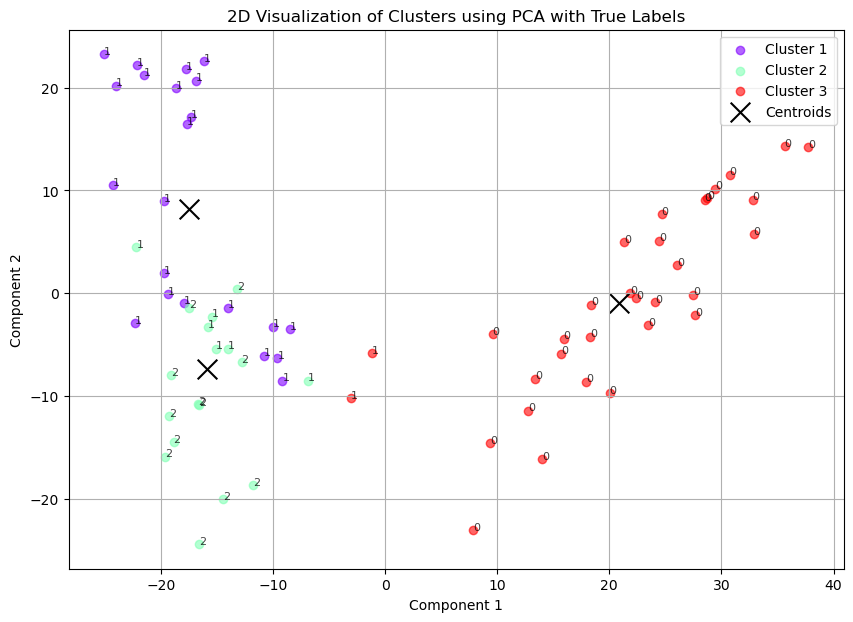

In [36]:
# Apply PCA after K-Means clustering for 2D visualization
X_2D_pca, centroids_2D_pca = reduce_to_2D_pca(feats_np, centroids)

# Plot the 2D clusters with centroids and true labels
plot_2D_clusters_with_labels(X_2D_pca, centroids_2D_pca, idx, labels_np, K)


In [22]:
total_data_points = 30+30+12
wrong = 3 
predicted_corrected = total_data_points - wrong
accuracy = (predicted_corrected/total_data_points)*100
print(accuracy)

95.83333333333334
